# 計算兩兩session間的最大均值差異(MMD)

In [1]:
import numpy as np
import torch
import new_get_data
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    params:
        source: sample_size_1 * feature_size 
        target: sample_size_2 * feature_size 
        kernel_mul: 计算每个核的bandwith
        kernel_num: 多核的数量
        fix_sigma: 固定的标准差
    return: (sample_size_1 + sample_size_2) * (sample_size_1 + sample_size_2)的
                        矩阵，表达形式:
                        [   K_ss K_st
                            K_ts K_tt ]
    """
    
    n_samples = int(source.size()[0])+int(target.size()[0])# 求矩阵的行数，一般source和target是一样的，便于计算
    total = torch.cat([source, target], dim=0) #将source,target按列方向合并
    #将total复制（n+m）份
    total0 = total.unsqueeze(0).expand(int(total.size(0)), \
                                       int(total.size(0)), \
                                       int(total.size(1))) #将total的每一行都复制成（n+m）行，即每个数据都扩展成（n+m）份
    total1 = total.unsqueeze(1).expand(int(total.size(0)), \
                                       int(total.size(0)), \
                                       int(total.size(1)))
    L2_distance = ((total0-total1)**2).sum(2) # 计算高斯核中的|x-y|

    # sigma of guassian_kernel
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    # 以fix_sigma为中值，以kernel_mul为倍数取kernel_num个bandwidth值（比如fix_sigma为1时，得到[0.25,0.5,1,2,4]
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]

    # 高斯核的公式，exp(-|x-y|/bandwith)
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for \
                  bandwidth_temp in bandwidth_list]

    return sum(kernel_val) # 将多个核合并在一起

def mmd(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n = int(source.size()[0])
    m = int(target.size()[0])

    kernels = guassian_kernel(source, target,
                              kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    XX = kernels[:n, :n] 
    YY = kernels[n:, n:]
    XY = kernels[:n, n:]
    YX = kernels[n:, :n]

    XX = torch.div(XX, n * n).sum(dim=1).view(1,-1)  # K_ss矩阵，Source<->Source
    XY = torch.div(XY, -n * m).sum(dim=1).view(1,-1) # K_st矩阵，Source<->Target

    YX = torch.div(YX, -m * n).sum(dim=1).view(1,-1) # K_ts矩阵,Target<->Source
    YY = torch.div(YY, m * m).sum(dim=1).view(1,-1)  # K_tt矩阵,Target<->Target
    	
    loss = (XX + XY).sum() + (YX + YY).sum()
    return loss

In [ ]:
matrix = np.zeros([37, 37])
for i in range(1, 38):
    soure, Train_vel, Test_fr, Test_vel = new_get_data.new_data_preprocessing(i)
    data_1 = torch.tensor(soure.squeeze())
    for j in range(1, 38):
        target, Train_vel, Test_fr, Test_vel = new_get_data.new_data_preprocessing(j)
        data_2 = torch.tensor(target.squeeze())
        print("MMD Loss:", mmd(data_1, data_2).numpy())
        matrix[i-1, j-1] = mmd(data_1, data_2).numpy()
classes = ['0407_02', '0411_01', '0411_02', '0418_01', '0419_01', 
    '0420_01', '0426_01', '0622_01', '0624_03', '0627_01', 
    '0630_01', '0915_01', '0916_01', '0921_01', '0927_04', 
    '0927_06', '0930_02', '0930_05', '1005_06', '1006_02', 
    '1007_02', '1011_03', '1013_03', '1014_04', '1017_02', 
    '1024_03', '1025_04', '1026_03', '1027_03', '1206_02', 
    '1207_02', '1212_02', '1220_02', '0123_02', '0124_01', 
    '0127_03', '0131_02']
fig = plt.figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(matrix, vmin=0, vmax=0.8, square=True, xticklabels=classes, yticklabels=classes, cmap='YlOrRd')
ax.set_title('Maximum Mean Discrepancy', fontsize = 30)

# 讀檔畫圖

In [1]:
import numpy as np
import torch
import new_get_data
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
a = np.load('mmd_cross_session(256).npy')
b = np.load('mmd_cross_session(1024).npy')
c = np.load('mmd_cross_session(2000).npy')

classes = ['0407_02', '0411_01', '0411_02', '0418_01', '0419_01', 
    '0420_01', '0426_01', '0622_01', '0624_03', '0627_01', 
    '0630_01', '0915_01', '0916_01', '0921_01', '0927_04', 
    '0927_06', '0930_02', '0930_05', '1005_06', '1006_02', 
    '1007_02', '1011_03', '1013_03', '1014_04', '1017_02', 
    '1024_03', '1025_04', '1026_03', '1027_03', '1206_02', 
    '1207_02', '1212_02', '1220_02', '0123_02', '0124_01', 
    '0127_03', '0131_02']
s = range(len(classes))

## session_1與其他session之間的距離

Text(0.5, 1.0, 'Maximum Mean Discrepancy')

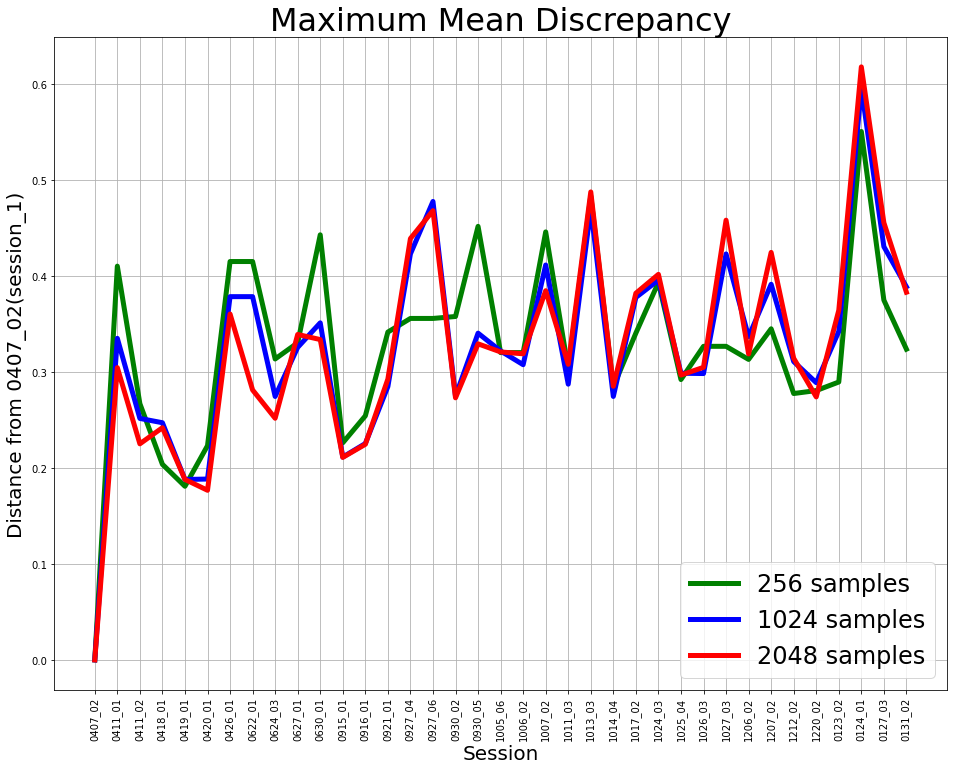

In [3]:
plt.figure(figsize=(16,12))
plt.plot(s, a[0, :], color='g', linewidth=5, label='256 samples')
plt.plot(s, b[0, :], color='b', linewidth=5, label='1024 samples')
plt.plot(s, c[0, :], color='r', linewidth=5, label='2048 samples')
plt.grid()
plt.legend(loc='lower right', fontsize=24)
plt.xticks(s, classes)
plt.xticks(rotation='vertical')
plt.xlabel('Session', fontsize=20)
plt.ylabel('Distance from 0407_02(session_1)', fontsize=20)
plt.title('Maximum Mean Discrepancy', fontsize=32)

## 兩兩session間的距離

Text(0.5, 1.0, 'Maximum Mean Discrepancy')

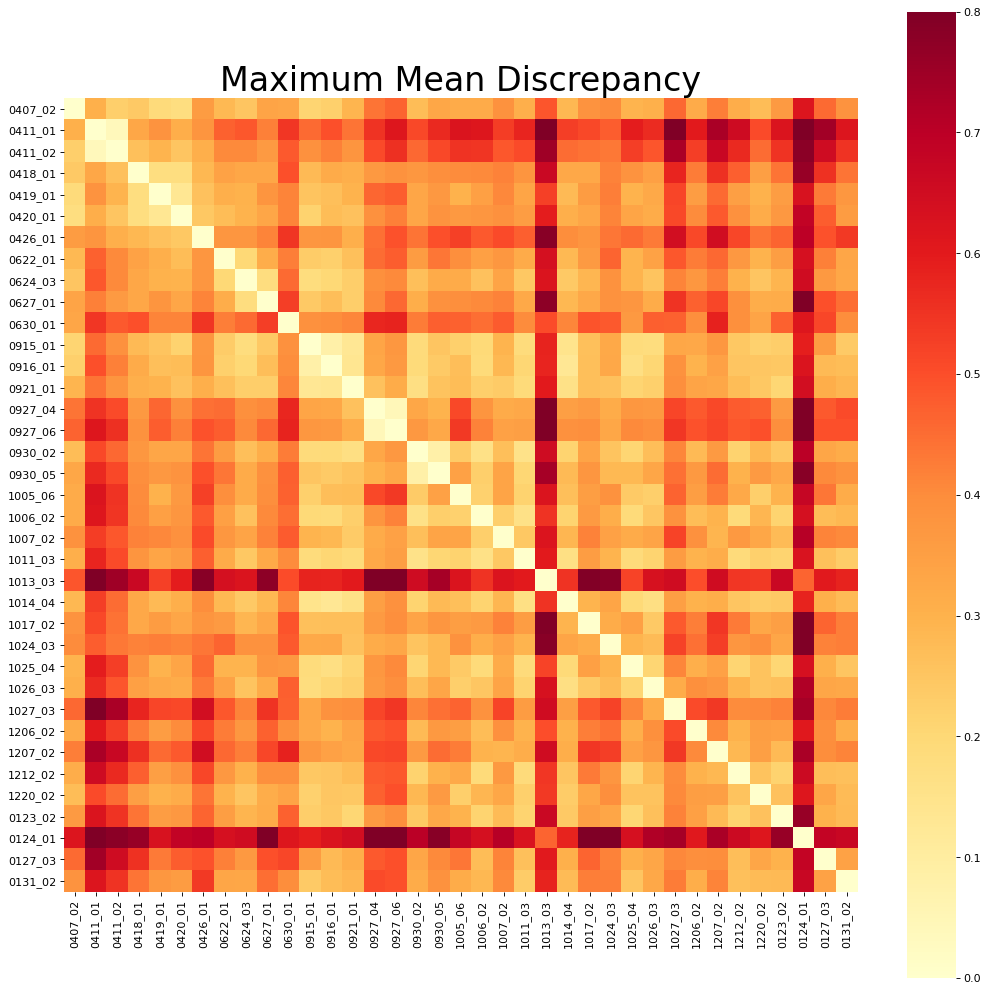

In [5]:
classes = ['0407_02', '0411_01', '0411_02', '0418_01', '0419_01', 
    '0420_01', '0426_01', '0622_01', '0624_03', '0627_01', 
    '0630_01', '0915_01', '0916_01', '0921_01', '0927_04', 
    '0927_06', '0930_02', '0930_05', '1005_06', '1006_02', 
    '1007_02', '1011_03', '1013_03', '1014_04', '1017_02', 
    '1024_03', '1025_04', '1026_03', '1027_03', '1206_02', 
    '1207_02', '1212_02', '1220_02', '0123_02', '0124_01', 
    '0127_03', '0131_02']
fig = plt.figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(c, vmin=0, vmax=0.8, square=True, xticklabels=classes, yticklabels=classes, cmap='YlOrRd')
ax.set_title('Maximum Mean Discrepancy', fontsize = 30)